# [NML-25] Notebook 2: Spectral Graph Theory

Responsible TA: [William Cappelletti](https://people.epfl.ch/william.cappelletti)

## Instructions


**Expected output:**

Troughout the different lab session, you will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable of function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your code should be self-contained in the `.ipynb` file. The solution to the exercices will be provided in an external `.ipynb` file.

* Try to make your code clean and readable, it is a good training for the project. Provide meaningful variable names and comment where needed.

* You cannot import any other library than we imported, unless explicitly stated.

## Objective

This assignment features three exercises: 
  - spectral clustering
  - spectral graph filtering


NB: You are encouraged to try different random seeds, remember to re-run the whole notebook after doing so.

### Setup

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans

rng = np.random.default_rng(235486)

## Section I: Spectral clustering

In this exercise, we will perform both positional-feature-based as well as spectral clustering on two different graph structures (disjoint box graphs and crescent moon) and analyze the influence of the features and graph on the obtained clusters.

*For additional information on spectral clustering, we refer to this [tutorial paper](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf). For practical aspects of the algorithm, the relevant sections are 1, 2, 3, 4, 8.*

### Load and visualize data

In [2]:
def get_boxes(num_boxes: int = 5, num_random_edges: int = 5):
    boxes = [nx.grid_2d_graph(m=n, n=n) for n in range(3, 3 + num_boxes)]
    pos = np.concatenate(
        [
            np.array(list(nx.kamada_kawai_layout(box).values())) + i * 1.25
            for i, box in enumerate(boxes)
        ]
    )
    G = nx.disjoint_union_all(boxes)
    return G, pos

In [3]:
def get_moons(num_moons: int = 5, num_points: int = 1000, eps: float = 2.5e-2):
    points = rng.uniform(-1, 1, size=(num_points, 2))
    x, y = points[:, 0], points[:, 1]
    circ = x**2 + y**2 <= 1
    circ2 = (x - 0.5) ** 2 + y**2 <= 1
    moon = points[circ & ~circ2]
    moons = np.concatenate(
        [
            np.array([1 - 2 * (i % 2), 1]) * (moon + np.array([0, i * 1.5]))
            for i in range(num_moons)
        ]
    )
    moon_dists = np.sum((moons[np.newaxis] - moons[:, np.newaxis]) ** 2, axis=2)
    moon_edges = np.vstack(((0 < moon_dists) & (moon_dists < eps)).nonzero()).T
    moon_graph = nx.empty_graph(n=len(moons))
    moon_graph.add_edges_from(moon_edges)
    return moon_graph, moons

In [4]:
def plot_graph(G, pos, node_clusters=None):
    plt.figure(figsize=(5, 5))
    nx.draw(
        G,
        pos=pos,
        node_size=10,
        node_color=(
            [plt.cm.Set1(c) for c in node_clusters]
            if node_clusters is not None
            else "gray"
        ),
    )
    plt.show()

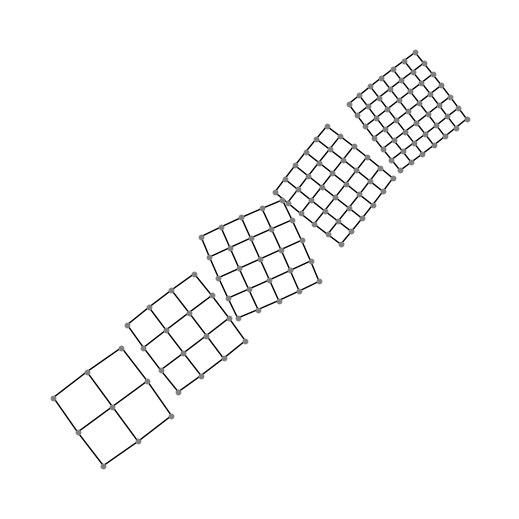

In [5]:
num_clusters = 5
G_boxes, G_boxes_pos = get_boxes(num_clusters)
plot_graph(G_boxes, G_boxes_pos)

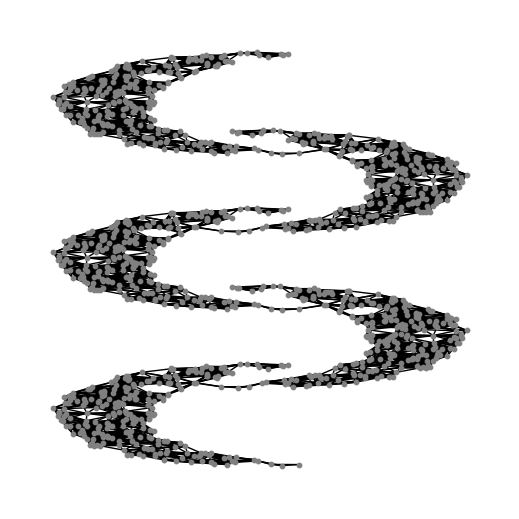

In [6]:
G_moons, G_moons_pos = get_moons(num_clusters)
plot_graph(G_moons, G_moons_pos)

### Part 1: K-means

#### Question 1.1: Run K-means with 5 clusters on both graphs.

You can use the scikit learn function (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [7]:
# Your solution here ###########################################################

G_boxes_clusters = KMeans(n_clusters=num_clusters, n_init=10).fit_predict(G_boxes_pos)
G_moons_clusters = KMeans(n_clusters=num_clusters, n_init=10).fit_predict(G_moons_pos)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

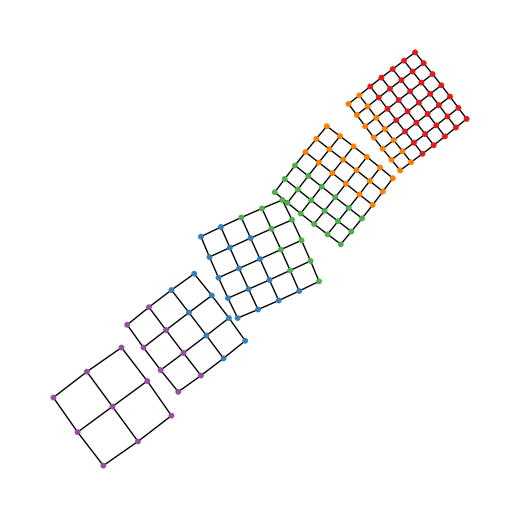

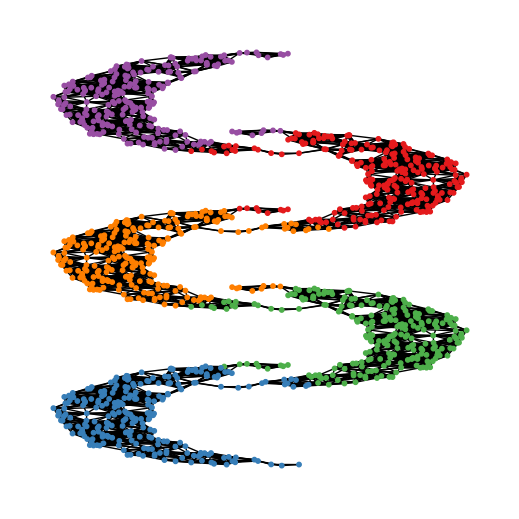

In [8]:
plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters)
plot_graph(G_moons, G_moons_pos, G_moons_clusters)

#### Question 1.2: Explain the limitations of K-means with respect to these data.

**Your answer here:**

K-means uses only the features (in this case positional embeddings of the nodes) to cluster them. In our case the boxes and moons are too close to each other while the moons are also not linearly separable and not blob-like. We need an algorithm that is density-based and also utilizes the graph connectivity too. 



### Part 2: Spectral clustering

#### Question 2.1: Fill `compute_laplacian`, `compute_number_connected_components`, `spectral decomposition`.

These functions should work for all 3 definitions of the laplacian (combinatorial, symmetric normalized, random walk).

*Warning:* the eigendecomposition of a non symmetric matrix returns complex numbers, even if the imaginary part is in fact 0.

In [9]:
def compute_laplacian(adjacency: np.ndarray, normalize: str):
    """normalize: can be None, 'sym' or 'rw' for the combinatorial, symmetric normalized or random walk Laplacians
    Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # Your solution here ###########################################################
    diag = np.sum(adjacency, axis=1)

    n = len(diag)
    D = np.diag(diag)  # Degree matrix
    combinatorial = D - adjacency

    if normalize is None:
        return combinatorial

    diag[diag == 0] = 1e-12
    if normalize == "sym":
        diag_norm = 1 / np.sqrt(diag)
        D_norm = np.diag(diag_norm)

        return np.eye(n) - D_norm @ adjacency @ D_norm

    elif normalize == "rw":
        diag_norm = 1 / diag
        D_norm = np.diag(diag_norm)
        return np.eye(n) - D_norm @ adjacency
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    else:
        raise ValueError(f"Unknown normalization: {normalize}")


def compute_number_connected_components(lamb: np.array, threshold: float):
    """lamb: array of eigenvalues of a Laplacian
    Return:
    n_components (int): number of connected components.
    """
    # Your solution here ###########################################################
    return np.count_nonzero(lamb <= threshold)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


def spectral_decomposition(laplacian: np.ndarray):
    """Return:
    lamb (np.array): eigenvalues of the Laplacian
    U (np.ndarray): corresponding eigenvectors.
    """
    # Your solution here ###########################################################
    if np.all(laplacian == laplacian.T):
        return np.linalg.eigh(laplacian)
    else:
        return np.linalg.eig(laplacian)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [10]:
def get_laplacians(G: nx.Graph):
    A = nx.adjacency_matrix(G).toarray().astype(float)

    laplacian_comb = compute_laplacian(A, normalize=None)

    laplacian_norm = compute_laplacian(A, normalize="sym")

    laplacian_rw = compute_laplacian(A, normalize="rw")

    return laplacian_comb, laplacian_norm, laplacian_rw


laplacian_comb_boxes, laplacian_norm_boxes, laplacian_rw_boxes = get_laplacians(G_boxes)
laplacian_comb_moons, laplacian_norm_moons, laplacian_rw_moons = get_laplacians(G_moons)

In [11]:
lamb_comb_boxes, U_comb_boxes = spectral_decomposition(laplacian_comb_boxes)
lamb_comb_moons, U_comb_moons = spectral_decomposition(laplacian_comb_moons)

lamb_norm_boxes, U_norm_boxes = spectral_decomposition(laplacian_norm_boxes)
lamb_norm_moons, U_norm_moons = spectral_decomposition(laplacian_norm_moons)

lamb_rw_boxes, U_rw_boxes = spectral_decomposition(laplacian_rw_boxes)
lamb_rw_boxes = np.real(lamb_rw_boxes)
lamb_rw_moons, U_rw_moons = spectral_decomposition(laplacian_rw_moons)
lamb_rw_moons = np.real(lamb_rw_moons)

#### Question 2.2: Implement spectral clustering, then compute it and plot it for each Laplacian definition

In [12]:
class SpectralClustering:
    def __init__(self, n_classes: int, normalize: str):
        self.n_classes = n_classes
        self.normalize = normalize
        # Your solution here ###########################################################
        self.clustering_method = KMeans(n_classes, n_init=10)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    def fit_predict(self, G: nx.Graph):
        """Your code should be correct both for the combinatorial
        and the symmetric normalized spectral clustering.
        Return:
        y_pred (np.ndarray): cluster assignments.
        """
        # Your solution here ###########################################################
        adjacency = nx.adjacency_matrix(G).toarray().astype(float)
        laplacian = compute_laplacian(adjacency, self.normalize)
        eigenvalues, U = spectral_decomposition(laplacian)

        eigenvalues = np.real(eigenvalues)
        U = np.real(U)

        # n_connected = compute_number_connected_components(eigenvalues, threshold=1e-12)
        # assert n_connected == 1, f"The graph seems to have {n_connected} connected components"

        first_columns = U[:, : self.n_classes]
        if self.normalize == "sym":
            norm = np.linalg.norm(first_columns, axis=1)[:, None]
            norm[norm < 1e-12] = 1
            first_columns = first_columns / norm

        y_pred = self.clustering_method.fit_predict(first_columns)
        return y_pred
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Spectral clustering with combinatorial Laplacian


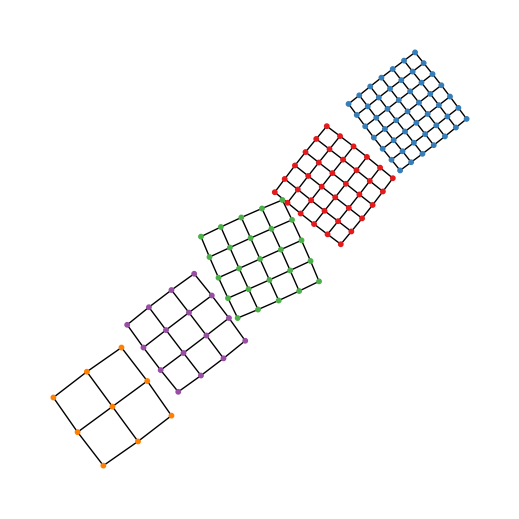

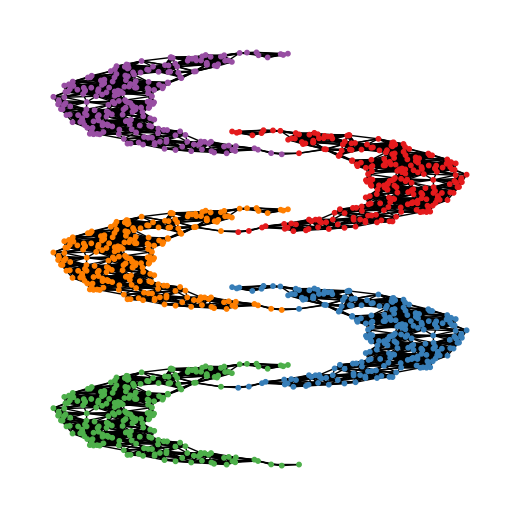

In [13]:
# Combinatorial Laplacian
print("Spectral clustering with combinatorial Laplacian")

# Your solution here ###################################################################

spectral_clustering = SpectralClustering(n_classes=num_clusters, normalize=None)
G_boxes_clusters_comb = spectral_clustering.fit_predict(G_boxes)
G_moons_clusters_comb = spectral_clustering.fit_predict(G_moons)

plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters_comb)
plot_graph(G_moons, G_moons_pos, G_moons_clusters_comb)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Spectral clustering with symmetric normalized Laplacian


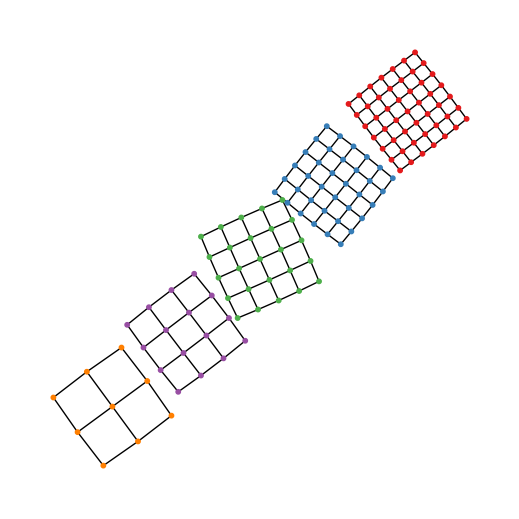

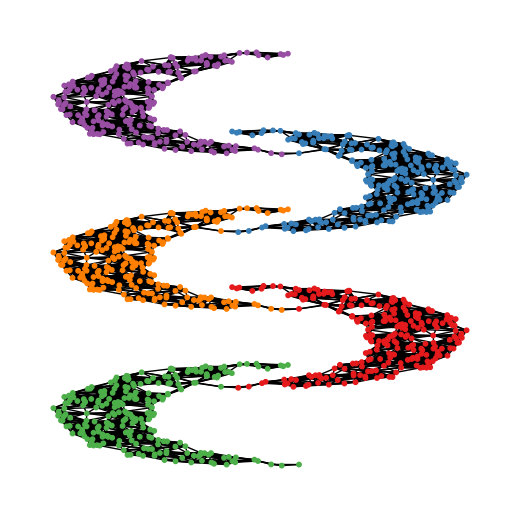

In [14]:
# Combinatorial Laplacian
print("Spectral clustering with symmetric normalized Laplacian")

# Your solution here ###################################################################

spectral_clustering_sym = SpectralClustering(n_classes=num_clusters, normalize="sym")
G_boxes_clusters_norm = spectral_clustering_sym.fit_predict(G_boxes)
G_moons_clusters_norm = spectral_clustering_sym.fit_predict(G_moons)

plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters_norm)
plot_graph(G_moons, G_moons_pos, G_moons_clusters_norm)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Spectral clustering with random walks Laplacian


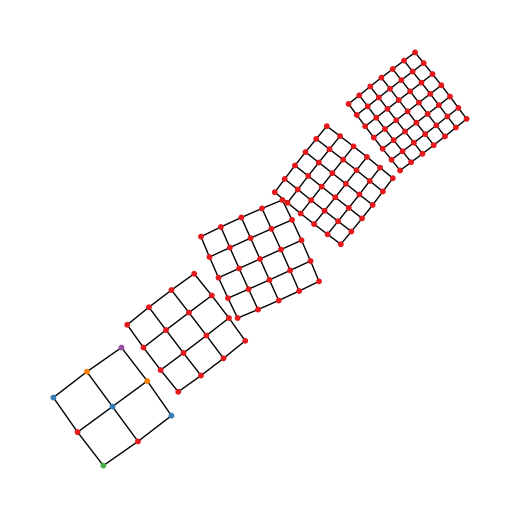

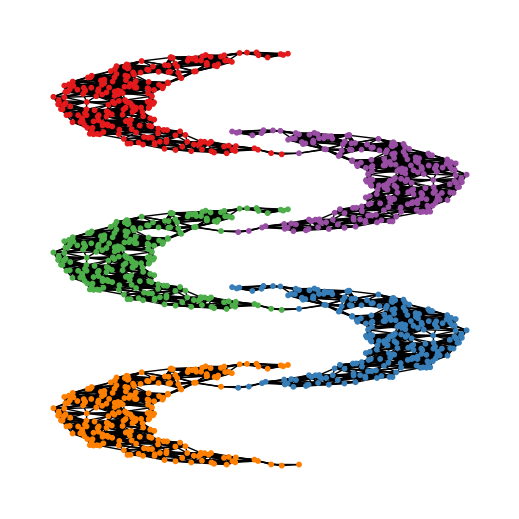

In [15]:
# Combinatorial Laplacian
print("Spectral clustering with random walks Laplacian")

# Your solution here ###################################################################

spectral_clustering_rw = SpectralClustering(n_classes=num_clusters, normalize="rw")
G_boxes_clusters_rw = spectral_clustering_rw.fit_predict(G_boxes)
G_moons_clusters_rw = spectral_clustering_rw.fit_predict(G_moons)

plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters_rw)
plot_graph(G_moons, G_moons_pos, G_moons_clusters_rw)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#### Question 2.3: Compare spectral clusters to K-means.

**Your answer here:**

*   Spectral clustering uses the graph connectivity to obtain node features, thus is invariant to positions of disconnected components
*   Laplacian normalization choices can affect results

